In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting
import stats
import pystan

reload(misc)
reload(plotting)

first_year = 1992

data_dir = '.'
data_file = os.path.join(data_dir, 'guncontrol_with_metadata_2017_04_05.csv')
data = misc.read_article_data(data_file, first_year, rename_frames=True)
print "Loaded data for %d articles" % len(data.index)

data['tone'] = data['Pro'] - data['Anti']

tone_annotations = misc.read_article_data(os.path.join(data_dir, 'guncontrol_tone_annotations.csv'), first_year)
print "Loaded tone annotations for %d articles" % len(tone_annotations.index)

tone_annotations['tone'] = tone_annotations['Pro'] - tone_annotations['Anti']

#framing_annotations = misc.read_article_data(os.path.join(data_dir, 'immigration_framing_annotations.csv'), first_year)
#framing_annotations = misc.compute_entropy(framing_annotations)
#print "Loaded framing annotations for %d articles" % len(framing_annotations.index)

last_date = data['date'].max() - pd.DateOffset(years=4)
print "Last date = ", last_date
last_year = last_date.year + 1

data = data[data['date'] <= last_date]
print data.shape


Loaded data for 16132 articles
Loaded tone annotations for 3707 articles
Last date =  2012-12-28 00:00:00
(11325, 28)


In [35]:
# extract periods from dates
reload(misc)
data = misc.convert_dates(data, first_year)
tone_annotations = misc.convert_dates(tone_annotations, first_year)
#framing_annotations = misc.convert_dates(framing_annotations, first_year)
print "Done"

Done


Grouped data into 84 periods


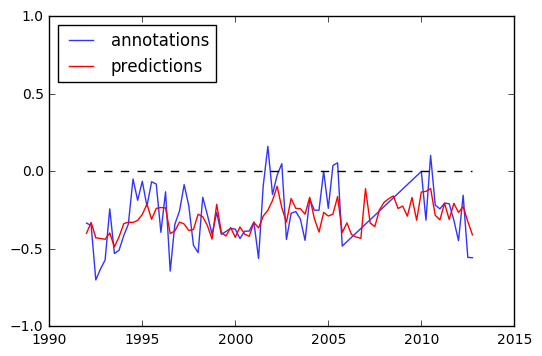

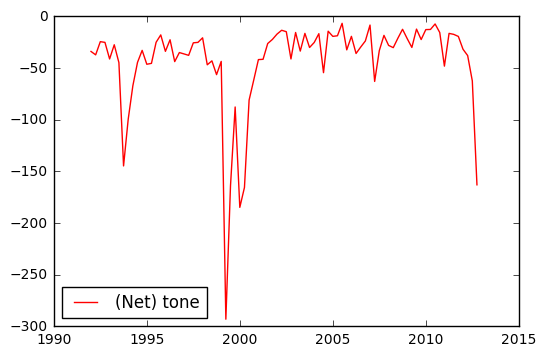

In [36]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'
#group_by = 'year'

reload(misc)
reload(plotting)

grouped = misc.group_article_data(data, group_by, first_year, group_tone=True, group_frames=True, group_directness=False)
grouped_tone_annotations = misc.group_article_data(tone_annotations, group_by, first_year, group_tone=True)
#grouped_framing_annotations = misc.group_article_data(framing_annotations, group_by, first_year, group_frames=True)

print "Grouped data into %d periods" % len(grouped.index)

fig, ax = plt.subplots()
#ax.fill_between(grouped_tone_annotations.f_date,  tone+tone_sd*2, tone-tone_sd*2, facecolor='grey', edgecolor='white', alpha=0.6)
ax.plot(grouped_tone_annotations.f_date, grouped_tone_annotations.tone / grouped_tone_annotations.stories, label='annotations', alpha=0.8)
ax.plot(grouped.f_date, grouped.tone / grouped.stories , 'r', label='predictions')
ax.plot([grouped.f_date.min(), grouped.f_date.max()], [0, 0], 'k--')
#ax.plot(grouped.f_date, grouped.Pro, c='purple', label='Pro')
#ax.plot(grouped.f_date, grouped.Anti, c='orange', label='Anti')
#ax.plot(grouped.f_date, grouped.Neutral, c='green', label='Neutral')
ax.legend(loc='upper left')
ax.set_ylim(-1, 1)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.tone , 'r', label='(Net) tone')
ax.legend(loc='lower left')


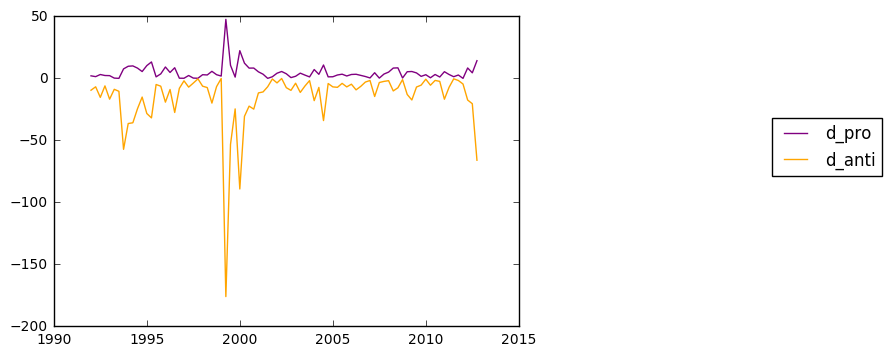

In [37]:
reload(misc)
grouped = misc.compute_entropy(grouped)
grouped['toneXentropy'] = grouped['tone'] * grouped['entropy']
    
grouped = misc.compute_dominance(grouped)
#grouped_framing_annotations = misc.compute_entropy(grouped_framing_annotations)

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.d_pro, c='purple', label='d_pro')
ax.plot(grouped.f_date, -grouped.d_anti, c='orange', label='d_anti')
grouped['d_diff'] = grouped['d_pro'] - grouped['d_anti']

ax.legend(loc='upper right', bbox_to_anchor=(1.8, 0.7))


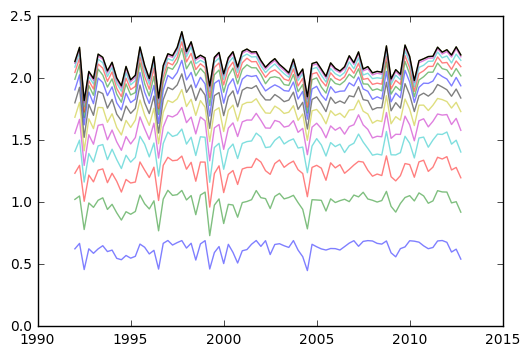

In [38]:
reload(misc)

fig, ax = plt.subplots()
grouped = misc.compute_truncated_entropy(grouped)
for j in range(2,15):
    ax.plot(grouped.f_date, grouped['entropy_' + str(j)], label='entropy_' + str(j), alpha=0.5)

ax.plot(grouped.f_date, grouped.entropy, label='entropy')

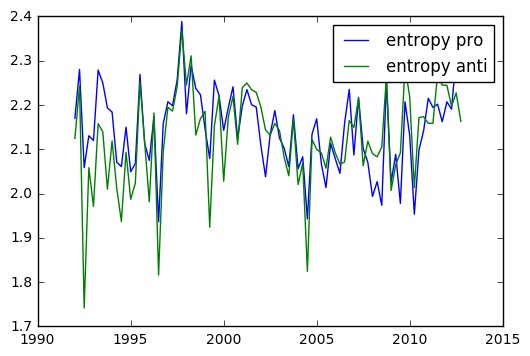

In [39]:
reload(misc)

grouped = misc.compute_signed_entropy(grouped)
fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.entropy_pro, label='entropy pro')
ax.plot(grouped.f_date, grouped.entropy_anti, label='entropy anti')
grouped['toneXentropyPro'] = grouped['tone'] * grouped['entropy_pro']
grouped['toneXentropyAnti'] = grouped['tone'] * grouped['entropy_anti']
ax.legend()

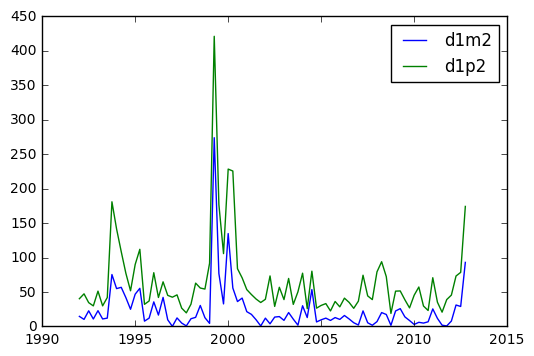

In [40]:
fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.d1m2, label='d1m2')
ax.plot(grouped.f_date, grouped.d1p2, label='d1p2')
ax.legend()
grouped['toneXd1m2'] = grouped['tone'] * grouped['d1m2']
grouped['toneXd1p2'] = grouped['tone'] * grouped['d1p2']



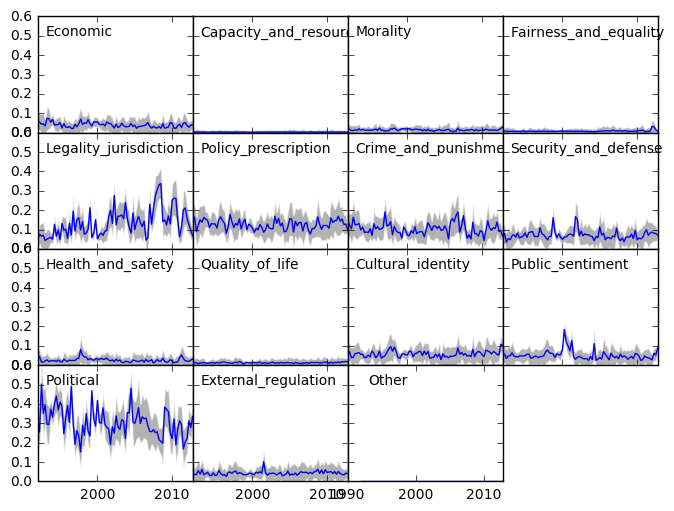

In [41]:
reload(plotting)
plotting.plot_frames(grouped, ymax=0.6)

1992
Loaded 158 polls
      Varname   House       Date  Topic  Subcode   L1   L2   L3   L4   C2  \
46   FIREARMS  GALLUP  3/30/1992     25       25   60  0.0  0.0  0.0  0.0   
166    GUNLAW    NORC  2/15/1993     25       25  245  0.0  0.0  0.0  0.0   
47   FIREARMS  GALLUP  3/12/1993     25       25   70  0.0  0.0  0.0  0.0   
265   HANDGUN   LHRES   4/3/1993     25       25   82  0.0  0.0  0.0  0.0   
167    GUNLAW    NORC  4/15/1993     25       25  625  0.0  0.0  0.0  0.0   

       ...     GUNSTRICT  STRICTORC  HANDGUN  GALGUN2  HANDGUNS GUNDIF  \
46     ...             0          0        0        0         0      0   
166    ...             0          0        0        0         0      0   
47     ...             0          0        0        0         0      0   
265    ...             0          0        1        0         0      0   
167    ...             0          0        0        0         0      0   

     HALLGUNS  GUNLAWY  GUNPEW  question  
46          0        0     

(<matplotlib.figure.Figure at 0x1191d0b90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1191d0790>)

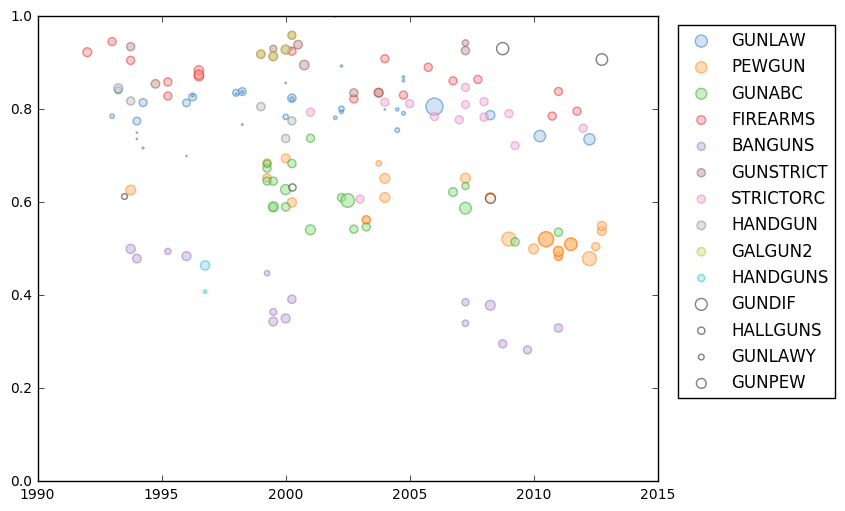

In [42]:
reload(misc)

filename = 'guncontrol_polls.csv'
print first_year
polls = misc.load_polls(filename, first_year, last_date)
# drop one poll that seems redundant (with a seeming mistake)
polls = misc.get_f_dates(polls, first_year, group_by)
print "Loaded %d polls" % len(polls.index)

# add in indicator variables for each question
varnames = polls['Varname'].values
#questions = list(set(varnames))
#questions.sort()
questions = misc.get_top_poll_questions(polls, n=len(varnames)+1)
question_index = dict(zip(questions, range(len(questions))))    
for q_i, q in enumerate(questions):
    polls.ix[:, q] = 0
for q_i, q in enumerate(questions):
    polls.ix[polls['Varname']==q, 'question'] = q_i
    polls.ix[polls['Varname']==q, q] = 1
print polls.head() 

reload(plotting)
#plotting.plot_polling_data(polls)
plotting.plot_polling_data(polls, transform=False)

(0, 1)

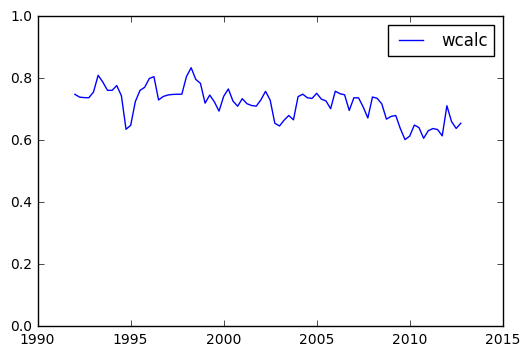

In [43]:
# Load data from wcalc
# specify the location of the mood data file
reload(misc)

group_by = 'quarter'
# read the mood data into a dataframe
if group_by == 'quarter':
    mood = pd.read_csv('wcalc_guncontrol_quarter_smoothed.csv', header=0)
    #mood = pd.read_csv('wcalc_immigration_quarter_unsmoothed.csv', header=0)
    mood['date'] = [pd.Timestamp(pd.datetime(int(mood.loc[i].year), (int(mood.loc[i].quarter))*3, 1)) for i in mood.index]
else:
    sys.exit()

mood = mood[mood['date'] >= pd.datetime(first_year, 1, 1)]
mood = mood[mood['date'] <= last_date]  

mood = misc.convert_dates(mood, first_year)
mood = misc.get_f_dates(mood, first_year, group_by)
mood.index = mood.p_quarter

# convert each quarter to a group (year/quarter)
if group_by == 'quarter':
    groups = mood.groupby('p_quarter')
elif group_by == 'month':
    groups = mood.groupby('p_month')
else:
    sys.exit()
    
# normalize and transform mood
mood['mood'] = mood['mood'] / 100.0
mood['transformed'] = np.log(mood.mood / (1 - mood.mood))

# store the vector of mood values from the previous quarter as a separate vector
mood['prev_mood'] = mood['mood'].shift().as_matrix()
mood['prev_transformed'] = mood['transformed'].shift().as_matrix()

# copy the mood data into the grouped dataframe (with the framing data)
grouped['mood'] = mood.mood
grouped['transformed'] = mood.transformed
grouped['prev_mood'] = mood.prev_mood
grouped['prev_transformed'] = mood.prev_transformed

#temp = pd.read_csv('immigration_grouped.csv')
#grouped['p_t'] = temp['p_t_means']

fig, ax = plt.subplots()
ax.plot(grouped.f_date, grouped.mood, label='wcalc')
#ax.plot(grouped.f_date, grouped.p_t, label='p_t')
ax.legend()
plt.ylim(0, 1)



In [44]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood'])


Rmse: 0.033391853652
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     124.6
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           4.69e-18
Time:                        14:05:59   Log-Likelihood:                 165.39
No. Observations:                  83   AIC:                            -326.8
Df Residuals:                      81   BIC:                            -322.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1544      0.05

In [54]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone'])


Rmse: 0.0334230219437
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     62.59
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           4.35e-17
Time:                        14:09:20   Log-Likelihood:                 165.83
No. Observations:                  83   AIC:                            -325.7
Df Residuals:                      80   BIC:                            -318.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1569      0.0

In [46]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'Pro', 'Anti'])


Rmse: 0.033148963789
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     43.20
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           1.26e-16
Time:                        14:06:08   Log-Likelihood:                 167.04
No. Observations:                  83   AIC:                            -326.1
Df Residuals:                      79   BIC:                            -316.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1254      0.05

In [55]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'd_pro', 'd_anti'])


Rmse: 0.0333786462351
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     42.24
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           2.16e-16
Time:                        14:09:43   Log-Likelihood:                 166.46
No. Observations:                  83   AIC:                            -324.9
Df Residuals:                      79   BIC:                            -315.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1480      0.0

In [49]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'd_diff'])


Rmse: 0.0333985744131
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     62.74
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           4.10e-17
Time:                        14:06:50   Log-Likelihood:                 165.89
No. Observations:                  83   AIC:                            -325.8
Df Residuals:                      80   BIC:                            -318.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1556      0.0

In [23]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy_pro', 'entropy_anti', 'toneXentropyPro', 'toneXentropyAnti'])



Rmse: 0.0337979935787
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     28.94
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           1.58e-18
Time:                        14:00:50   Log-Likelihood:                 182.77
No. Observations:                  91   AIC:                            -351.5
Df Residuals:                      84   BIC:                            -334.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         

In [50]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy'])


Rmse: 0.0335877735332
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     41.39
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           3.52e-16
Time:                        14:07:01   Log-Likelihood:                 165.95
No. Observations:                  83   AIC:                            -323.9
Df Residuals:                      79   BIC:                            -314.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.1937      0.0

In [56]:
fitted, rmse = stats.ols(df=grouped, target='mood', columns=['prev_mood', 'tone', 'entropy', 'toneXentropy'])


Rmse: 0.0337587429786
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     30.78
Date:                Wed, 05 Apr 2017   Prob (F-statistic):           2.25e-15
Time:                        14:10:07   Log-Likelihood:                 166.05
No. Observations:                  83   AIC:                            -322.1
Df Residuals:                      78   BIC:                            -310.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.1600   